# Accessing data from Sup3rCC on AWS and visualize the trend of solar / wind / temperature / pressure in WV Marion County into Year 2059

## What is `Sup3rCC`?
The Super-Resolution for Renewable Energy Resource Data with Climate Change Impacts (`Sup3rCC`) data is a collection of 4km hourly wind, solar, temperature, humidity, and pressure fields for the contiguous United States under various climate change scenarios. It utilizes a generative machine learning approach called `Sup3r` (Super-Resolution for Renewable Energy Resource Data) to downscale Global Climate Model (GCM) data.


### References:
- [Github resources of Sup3r](https://github.com/NREL/sup3r)
- [AWS Bucket of Sup3rCC](https://us-west-2.console.aws.amazon.com/s3/buckets/nrel-pds-sup3rcc?region=us-west-2&bucketType=general&tab=objects)

---



## Data Access

### Run a nested loop to fetch data on AWS

In [54]:
# import libraries
from alive_progress import alive_bar
import pandas as pd
import xarray as xr
import s3fs
import os

# s3fs is the package used to access AWS S3 buckets
# the data is public, no need for credentials
fs = s3fs.S3FileSystem(anon=True)
appended_data = []
# the data covers year from 2015 to 2059
start_year = 2015
end_year = 2059
# specify climate data types and attributes 
climate_type = ['solar', 'wind', 'trh', 'pressure']
attr = ['ghi', 'windspeed_10m', 'temperature_2m', 'pressure_0m']
climate_attr_dict = {climate_type: attr for climate_type, attr in zip(climate_type, attr)}
# calculate the total number in the loop
climate_type_num = len(climate_type)
year_num = len(range(start_year, end_year + 1))
loop_total_num = year_num * climate_type_num
# specify the components of the S3 URI
cloud_type = "s3://"
bucket = "nrel-pds-sup3rcc/"
folder = "conus_mriesm20_ssp585_r1i1p1f1/"
version = "v0.1.0/"
file_base = "sup3rcc_conus_mriesm20_ssp585_r1i1p1f1"
file_extension = "h5"
URI_base = os.path.join(cloud_type, bucket, folder, version, file_base)

with alive_bar(loop_total_num, force_tty=True, title='Running', length=20, bar = 'smooth') as bar:

    for climate in climate_type:
        
        for year in range(start_year, end_year + 1):
             
            URI = f"{URI_base}_{climate}_{year}.{file_extension}"
            # use `xarray` with engine `h5netcdf` to access data
            ds = xr.open_dataset(fs.open(URI), backend_kwargs={"phony_dims": "sort"}, engine='h5netcdf')
            time_index = pd.to_datetime(ds['time_index'][...].astype(str))
            meta = pd.DataFrame(ds.meta.data)
            # get index of WV Marion County from the meta data
            WV_MarionCounty_index = meta[(meta['state'] == b'West Virginia') & (meta['county'] == b'Marion')].index[0]
            attr = [v for k, v in climate_attr_dict.items() if climate == k]
            attr = ','.join(map(str, attr))
            # subset the data with specified attribute, all time index, and WV Marion County index
            subset = ds[attr][:, WV_MarionCounty_index].load()
            data = pd.DataFrame({f"{attr}" : subset}, index = time_index)
            appended_data.append(data)
            bar()

# concatenate all the data and groupby year to get the mean value
final_data = pd.concat(appended_data)
group_data = final_data.groupby(final_data.index.year).mean()
group_data.head()

Running |████████████████████| 180/180 [100%] in 44:22.5 (0.07/s)               


,ghi,windspeed_10m,temperature_2m,pressure_0m
2015,169.190186,31900.580078,113992.656250,970.101807
2016,160.562042,30269.455078,122115.843750,971.240906
2017,163.173401,31733.482422,116663.804688,970.130798
2018,163.853317,29975.697266,115782.156250,969.629089
2019,164.436646,31382.476562,116853.218750,971.139282


## Data Visualization

### Create 3 subplots to see the trend of ghi, windspeed_10m, and temperature_2m through year 2059

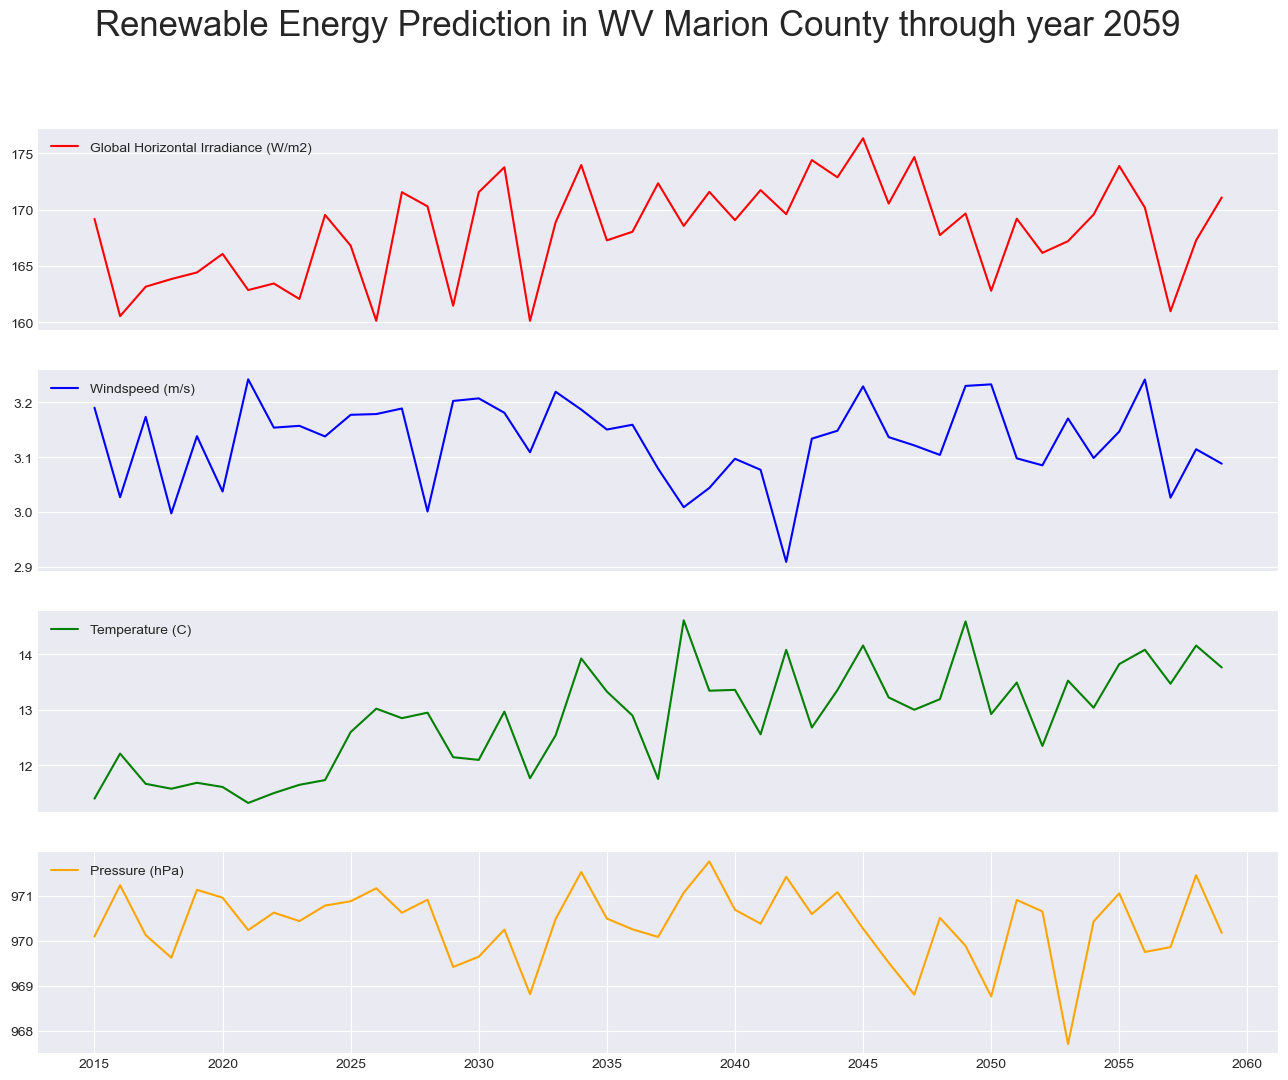

In [59]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

fig, axs = plt.subplots(4, figsize=(16,12), sharex=True)
fig.suptitle('Renewable Energy Prediction in WV Marion County through year 2059', fontsize = 25)
axs[0].plot(group_data.ghi, color = 'r', label = "Global Horizontal Irradiance (W/m2)")
axs[0].legend(loc="upper left")
axs[0].get_xaxis().set_visible(False)
axs[1].plot(group_data.windspeed_10m / 10000, color = 'b', label = "Windspeed (m/s)")
axs[1].legend(loc="upper left")
axs[1].get_xaxis().set_visible(False)
axs[2].plot(group_data.temperature_2m / 10000, color = 'g', label = "Temperature (C)")
axs[2].legend(loc="upper left")
axs[2].get_xaxis().set_visible(False)
axs[3].plot(group_data.pressure_0m, color = 'orange', label = "Pressure (hPa)")
axs[3].legend(loc="upper left")
plt.xticks(range(2015, 2065, 5))
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
#plt.savefig("Renewable Energy Prediction.png") 
plt.show()